### Installation von YOLOv5 mit Git und pip

In [ ]:
!git clone "https://github.com/ultralytics/yolov5.git"
%cd yolov5
%pip install -qr requirements.txt
%cd ..

### Imports

In [1]:
import os
import json
import shutil
import cv2
from sklearn.model_selection import train_test_split

### Kopieren von Bildern in den YOLOv5-Dataset-Ordner und Konvertieren von JSON-Daten in das YOLOv5-Format (txt)


In [ ]:
# Pfad zu den JSON-Daten und Bildern
json_dir = "../Datasets/Kaggle Face Mask Detection Full/dark/annotations" 
image_dir = "../Datasets/Kaggle Face Mask Detection Full/dark/images"

# Pfad zu den YOLOv5 Dataset-Ordnern
labels_output_dir = "yolov5/dataset/dark/labels"  
image_output_dir = "yolov5/dataset/dark/images"  

# Bilder und Annotationen einlesen
images = [os.path.join(image_dir, x) for x in os.listdir(image_dir)]
annotations = [os.path.join(json_dir, x) for x in os.listdir(json_dir) if x.endswith(".json")]

# Train-Test-Split
if len(images) < 2 or len(annotations) < 2:
    print("Nicht genügend Datenpunkte für den Split vorhanden.")
    exit()

# Train-Test-Split
train_images, test_images, train_annotations, test_annotations = train_test_split(images, annotations, test_size=0.3, random_state=1)
# Validierungs-Split
val_images, test_images, val_annotations, test_annotations = train_test_split(test_images, test_annotations, test_size=0.5, random_state=1)


In [ ]:
# Funktion zum Kopieren von Dateien
def copy_files_to_folder(file_list, destination_folder):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    for file_path in file_list:
        file_name = os.path.basename(file_path)
        destination_path = os.path.join(destination_folder, file_name)
        shutil.copy(file_path, destination_path)

In [20]:
# Funktion zur Konvertierung der Labels ins YOLOv5-Format
def convert_labels_to_yolov5_format(json_path, image_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    class_mapping = {
        "face_no_mask": 0,
        "face_with_mask": 1,
        "mask_surgical": 2,
        "hat": 3,
        "eyeglasses": 4,
        "face_other_covering": 5,
        "face_with_mask_incorrect": 6,
        "mask_colorful": 7,
        "helmet": 8,
        "sunglasses": 9,
        "scarf_bandana": 10,
        "hair_net": 11,
        "goggles": 12,
        "face_shield": 13,
        "hijab_niqab": 14,
        "turban": 15,
        "balaclava_ski_mask": 16,
        "gas_mask": 17,
        "hood": 18,
        "other": 19
    }

    # Erstelle YOLOv5-Annotationen
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    image = cv2.imread(image_path)
    image_height, image_width, _ = image.shape

    yolo_annotations = []
    for bbox in json_data["Annotations"]:
        x_min, y_min, x_max, y_max = bbox["BoundingBox"]
        class_name = bbox["classname"]

        if class_name not in class_mapping:
            raise ValueError(f"Ungültige Klasse: {class_name}")

        class_index = class_mapping[class_name]

        # Normalisierung der Koordinaten
        x_center = (x_min + x_max) / (2 * image_width)
        y_center = (y_min + y_max) / (2 * image_height)
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height

        yolo_annotation = f"{class_index} {x_center} {y_center} {width} {height}"
        yolo_annotations.append(yolo_annotation)

    image_filename = os.path.splitext(os.path.basename(image_path))[0]
    output_filename = f"{image_filename}.txt"
    output_path = os.path.join(output_dir, output_filename)

    with open(output_path, 'w') as f:
        for annotation in yolo_annotations:
            f.write(annotation + '\n')

    # Erstelle classes.txt-Datei
    classes_file_path = os.path.join(output_dir, "classes.txt")
    with open(classes_file_path, 'w') as f:
        for class_name, class_index in class_mapping.items():
            f.write(f"{class_index} {class_name}\n")

# Bilder in Trainings-, Validierungs- und Testordner kopieren
train_image_output_dir = os.path.join(image_output_dir, "train")
val_image_output_dir = os.path.join(image_output_dir, "val")
test_image_output_dir = os.path.join(image_output_dir, "test")
copy_files_to_folder(train_images, train_image_output_dir)
copy_files_to_folder(val_images, val_image_output_dir)
copy_files_to_folder(test_images, test_image_output_dir)

# Labels in den entsprechenden Ordnern kopieren und ins YOLOv5-Format konvertieren
train_labels_output_dir = os.path.join(labels_output_dir, "train")
val_labels_output_dir = os.path.join(labels_output_dir, "val")
test_labels_output_dir = os.path.join(labels_output_dir, "test")
copy_files_to_folder(train_annotations, train_labels_output_dir)
copy_files_to_folder(val_annotations, val_labels_output_dir)
copy_files_to_folder(test_annotations, test_labels_output_dir)

# Labels ins YOLOv5-Format konvertieren
for json_path, image_path in zip(train_annotations, train_images):
    convert_labels_to_yolov5_format(json_path, image_path, train_labels_output_dir)

for json_path, image_path in zip(val_annotations, val_images):
    convert_labels_to_yolov5_format(json_path, image_path, val_labels_output_dir)

for json_path, image_path in zip(test_annotations, test_images):
    convert_labels_to_yolov5_format(json_path, image_path, test_labels_output_dir)

print("Split, Kopieren und Konvertieren erfolgreich.")

Split, Kopieren und Konvertieren erfolgreich.


In [21]:
#JSON-Dateien aus yolov5/dataset löschen
def delete_json_files(folders):
    for folder in folders:
        if not os.path.exists(folder):
            continue
        
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            
            if filename.endswith(".json"):
                os.remove(file_path)

folders = [
    "yolov5/dataset/labels/train",
    "yolov5/dataset/labels/test",
    "yolov5/dataset/labels/val",
]

delete_json_files(folders)

### Training von YOLOv5 mit WandB-Integration und Upload des Datasets

conda install pytorch=1.9.0 cudatoolkit=11.1 -c pytorch -c conda-forge  
damit es läuft
torchvision               0.10.0+cu111

In [1]:
import torch
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.9.0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080', major=8, minor=6, total_memory=10239MB, multi_processor_count=68)


In [2]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saniye-ogul98 (chillibuddies). Use `wandb login --relogin` to force relogin


True

In [3]:
%cd yolov5

c:\Users\Saniye\Documents\GitHub\Deep-Vision-sta\YOLO\yolov5


In [4]:
!python train.py --data dataset/data.yaml --epochs 10 --weights '' --cfg yolov5s.yaml  --batch-size 6 --upload_dataset --bbox_interval 1 --img 640

wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: saniye-ogul98 (chillibuddies). Use `wandb login --relogin` to force relogin
train: weights='', cfg=yolov5s.yaml, data=dataset/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=6, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=True, bbox_interval=1, artifact_alias=latest
github:  YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-192-

In [27]:
# Zelle 1: Trainingscode
!python train.py --data dataset/data.yaml --epochs 10 --weights '' --cfg yolov5s.yaml --batch-size 6 --upload_dataset --bbox_interval 1 --img 640

precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne
precision & recall 
vor if
Drinne


wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Currently logged in as: saniye-ogul98 (chillibuddies). Use `wandb login --relogin` to force relogin
train: weights='', cfg=yolov5s.yaml, data=dataset/data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=10, batch_size=6, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=True, bbox_interval=1, artifact_alias=latest
github:  YOLOv5 is out of date by 1 commit. Use 'git pull' or 'git clone https://github.com/ultralytics/yolov5' to update.
YOLOv5  v7.0-192-

In [28]:
import json
import matplotlib.pyplot as plt

# Laden Sie die Verluste und den IoU-Wert aus der Datei
with open('metrics.json', 'rb') as f:
    data = json.load(f)

losses = data['losses']
results = data['results']

# Separate precision and recall values for each class
precisions = results[1::2]
recalls = results[0::2]

# Calculate average precision
average_precision = sum(precisions) / len(precisions)

# Calculate average recall
average_recall = sum(recalls) / len(recalls)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)




Average Precision: 0.08696382108355387
Average Recall: 0.27690866076630954


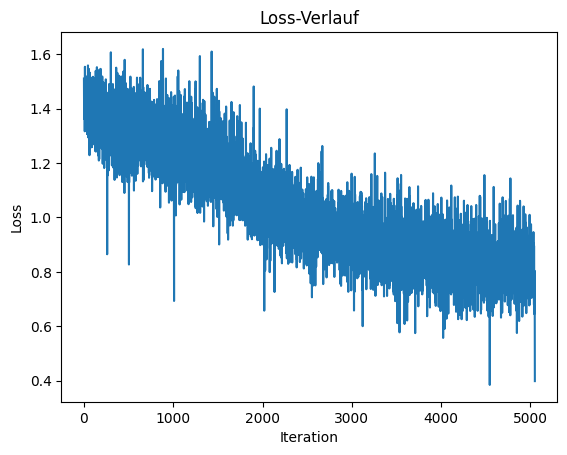

In [29]:
# Erstellen Sie ein Diagramm für die Loss-Werte
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss-Verlauf')
plt.show()

In [ ]:
%matplotlib inline

# Convert the arrays to numpy arrays for easier plotting
ap_values = np.array(ap_values)
ar_values = np.array(ar_values)

iou_thresholds_available = ["0.50:0.95", "0.50", "0.75", "0.50:0.95_small", "0.50:0.95_medium", "0.50:0.95_large"]

# Plot the average precisions over epochs
plt.figure(figsize=(10, 5))
for i, iou_thresh in enumerate(iou_thresholds_available):
    plt.plot(ap_values[:, i], label=f"IoU={iou_thresh}")
plt.xlabel("Epochs")
plt.ylabel("Average Precision")
plt.title("Average Precision vs. Epochs")
plt.legend()
plt.show()

# Plot the average recalls over epochs
plt.figure(figsize=(10, 5))
for i, iou_thresh in enumerate(iou_thresholds_available):
    plt.plot(ar_values[:, i], label=f"IoU={iou_thresh}")
plt.xlabel("Epochs")
plt.ylabel("Average Recall")
plt.title("Average Recall vs. Epochs")
plt.legend()
plt.show()

In [32]:
!python segment/predict.py --weights yolov5s-seg.pt --img 640 --conf 0.25 --source dataset/images/test/1804.jpg

segment\predict: weights=['yolov5s-seg.pt'], source=dataset/images/test/1804.jpg, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5  v7.0-192-g459dd49 Python-3.9.16 torch-1.9.0 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)

Fusing layers... 
YOLOv5s-seg summary: 224 layers, 7611485 parameters, 0 gradients, 26.4 GFLOPs
image 1/1 C:\Users\Saniye\Documents\GitHub\Deep-Vision-sta\YOLO\yolov5\dataset\images\test\1804.jpg: 640x448 2 persons, 7.5ms
Speed: 0.0ms pre-process, 7.5ms inference, 3.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs\predict-seg\exp3
